# Objetivo do Estudo: Operação de FPSO
O objetivo deste estudo é quantificar os riscos associados à operação de uma embarcação de Produção, Armazenamento e Transferência Flutuante (FPSO). Para garantir o êxito na operação de um FPSO, sensores são utilizados para mitigar o risco de falha de equipamentos. Esses sensores medem vários parâmetros dos equipamentos sob diferentes configurações de instalação (predefinição 1 e predefinição 2) ao longo do tempo. Além disso, existem variáveis inerentes que podem aumentar ainda mais o risco de falha dos equipamentos.

# Bibliotecas

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
#from scipy.spatial.distance import cdist, pdist

import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate


from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler,OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,roc_curve,auc
from sklearn.model_selection import GridSearchCV


from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

# Dados Importação

In [3]:
df = pd.read_excel('/content/O_G_Equipment_Data.xlsx')

In [4]:
df.head()

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail
0,1,3,6,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,False
1,2,2,4,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,False
2,3,2,1,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,False
3,4,2,3,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,False
4,5,2,5,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,False


# Analise dos Dados

Os dados possuem a seguinte estrutura:

10 colunas

9 colunas numéricas 1 coluna booleana Sem informações ausentes.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Cycle        800 non-null    int64  
 1   Preset_1     800 non-null    int64  
 2   Preset_2     800 non-null    int64  
 3   Temperature  800 non-null    float64
 4   Pressure     800 non-null    float64
 5   VibrationX   800 non-null    float64
 6   VibrationY   800 non-null    float64
 7   VibrationZ   800 non-null    float64
 8   Frequency    800 non-null    float64
 9   Fail         800 non-null    bool   
dtypes: bool(1), float64(6), int64(3)
memory usage: 57.2 KB


In [6]:
df.nunique()

Cycle          800
Preset_1         3
Preset_2         8
Temperature    800
Pressure       800
VibrationX     800
VibrationY     800
VibrationZ     800
Frequency      800
Fail             2
dtype: int64

# Calcular quantas vezes o equipamento falhou.

Como pode ser visto, a informação de "Falha" está desequilibrada, e nos próximos passos teremos que corrigi-la para executar um classificador de aprendizado de máquina.

In [7]:
print('Distribuição de Falhos:')
print(df.Fail.value_counts())
print()

print('Distribuição de Falhos (%):')
print((df.Fail.value_counts() / df.shape[0]) * 100)

Distribuição de Falhos:
False    734
True      66
Name: Fail, dtype: int64

Distribuição de Falhos (%):
False    91.75
True      8.25
Name: Fail, dtype: float64


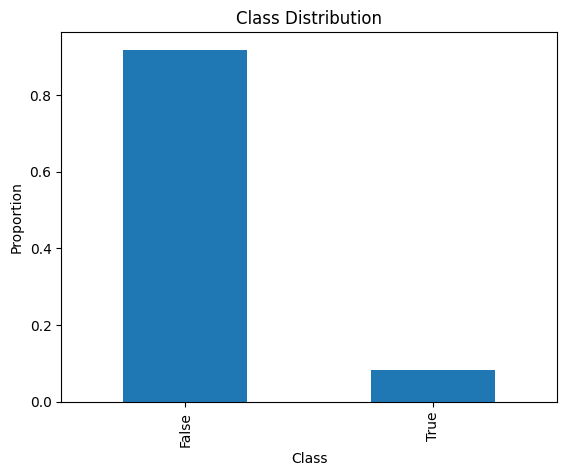

In [8]:
class_count = df["Fail"].value_counts()
class_proportion = class_count / class_count.sum()
class_proportion.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Proportion')
plt.title('Class Distribution')
plt.show()

# Estatísticas descritivas dos dados
Já é perceptível alguma possibilidade de valores discrepantes, que serão analisados mais cuidadosamente posteriormente.

In [9]:
df.describe()

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency
count,800.0000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,400.5000,1.988750,4.551250,69.263494,78.997945,73.860275,72.786878,71.866211,68.223449
std,231.0844,0.805875,2.293239,25.536252,32.501834,31.229631,32.739745,27.844616,29.138702
min,1.0000,1.000000,1.000000,2.089354,3.480279,3.846343,10.057744,18.784169,4.380101
25%,200.7500,1.000000,3.000000,51.040134,55.508564,50.752461,48.523982,50.787638,45.861762
50%,400.5000,2.000000,5.000000,65.906716,75.014848,69.394953,65.504770,69.319237,65.664252
75%,600.2500,3.000000,7.000000,80.527220,99.302530,90.195059,94.075572,88.891205,90.097457
max,800.0000,3.000000,8.000000,255.607829,189.995681,230.861142,193.569947,230.951134,178.090303


# Checar Outliers
Com base no estudo abaixo, podemos observar que a proporção de valores discrepantes é muito baixa, com uma média de cerca de 2% de todos os dados. Com esse número, podemos prosseguir com os dados e continuar nossa análise.

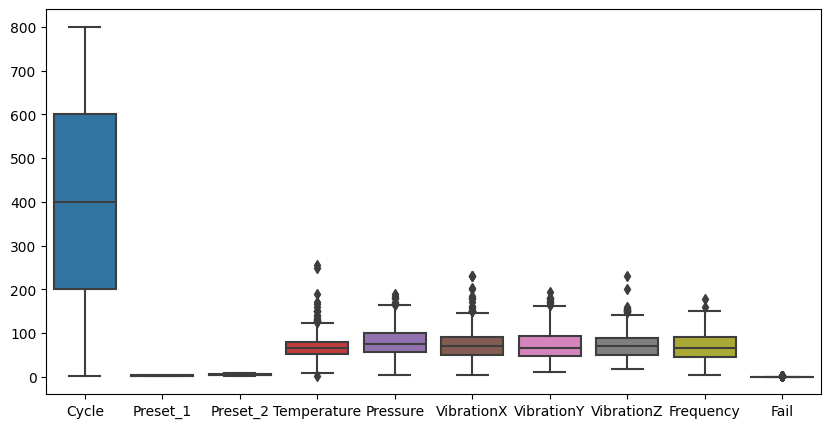

In [10]:

fig, ax = plt.subplots(figsize=(10, 5))

sns.boxplot(data=df, ax=ax)

plt.show()

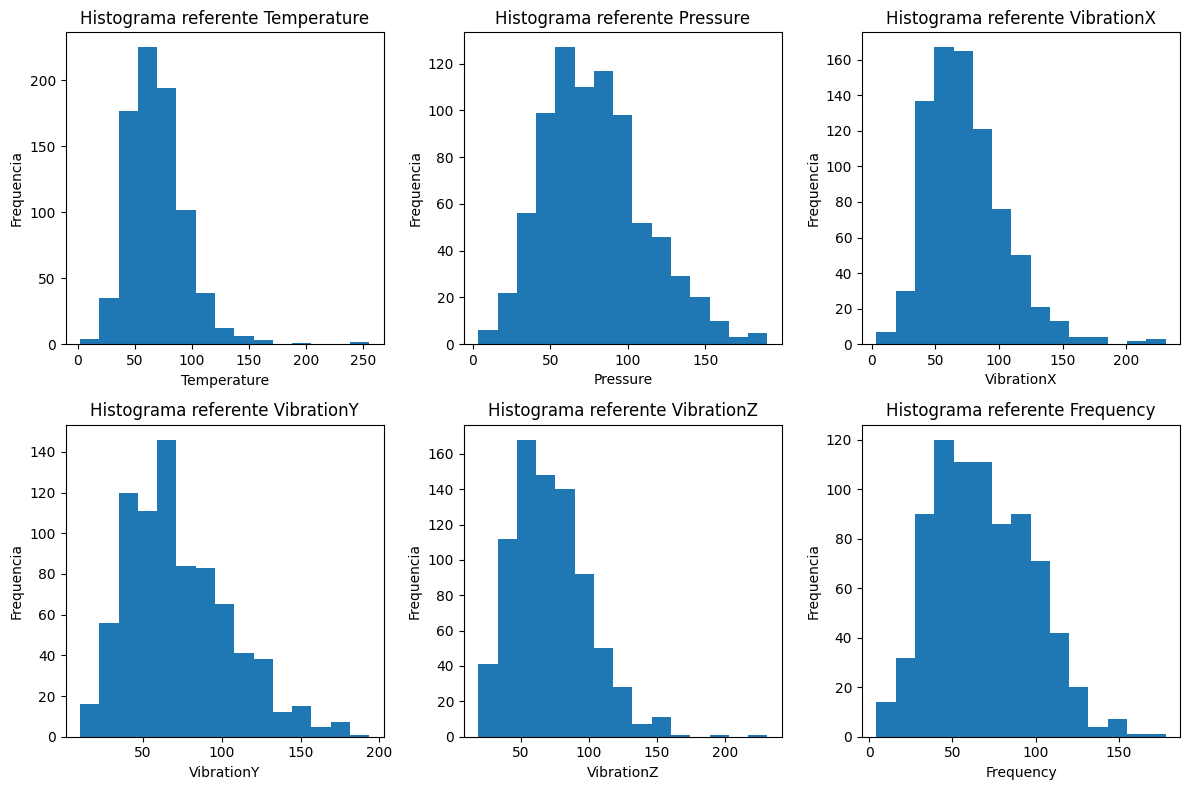

In [11]:

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))


columns = ["Temperature", "Pressure", "VibrationX", "VibrationY", "VibrationZ", "Frequency"]


for i, column in enumerate(columns):
    row = i // 3
    col = i % 3

    axes[row, col].hist(df[column], bins=15)
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel("Frequencia")
    axes[row, col].set_title(f"Histograma referente {column}")

plt.tight_layout()

plt.show()

In [12]:

outlier_percentages = {}

for column in columns:
    Q1 = np.percentile(df[column], 25)
    Q3 = np.percentile(df[column], 75)
    IQR = Q3 - Q1
    outliers = df[(df[column] < Q1 - 1.5 * IQR) | (df[column] > Q3 + 1.5 * IQR)]
    outlier_percentage = len(outliers) / len(df) * 100
    outlier_percentages[column] = outlier_percentage

for column, percentage in outlier_percentages.items():
    print(f"Percentage of outliers for column '{column}': {percentage:.2f}%")

Percentage of outliers for column 'Temperature': 2.75%
Percentage of outliers for column 'Pressure': 1.00%
Percentage of outliers for column 'VibrationX': 2.50%
Percentage of outliers for column 'VibrationY': 1.25%
Percentage of outliers for column 'VibrationZ': 1.75%
Percentage of outliers for column 'Frequency': 0.25%


# Analisar a importância das variáveis.
De acordo com a análise de correlação das variáveis abaixo, podemos confirmar que as variáveis que têm o impacto mais significativo na saúde dos nossos equipamentos, em ordem decrescente, são as vibrações (Y e Z), pressão e frequência. Posteriormente, iremos criar uma nova variável para o nosso estudo.

## Correlação

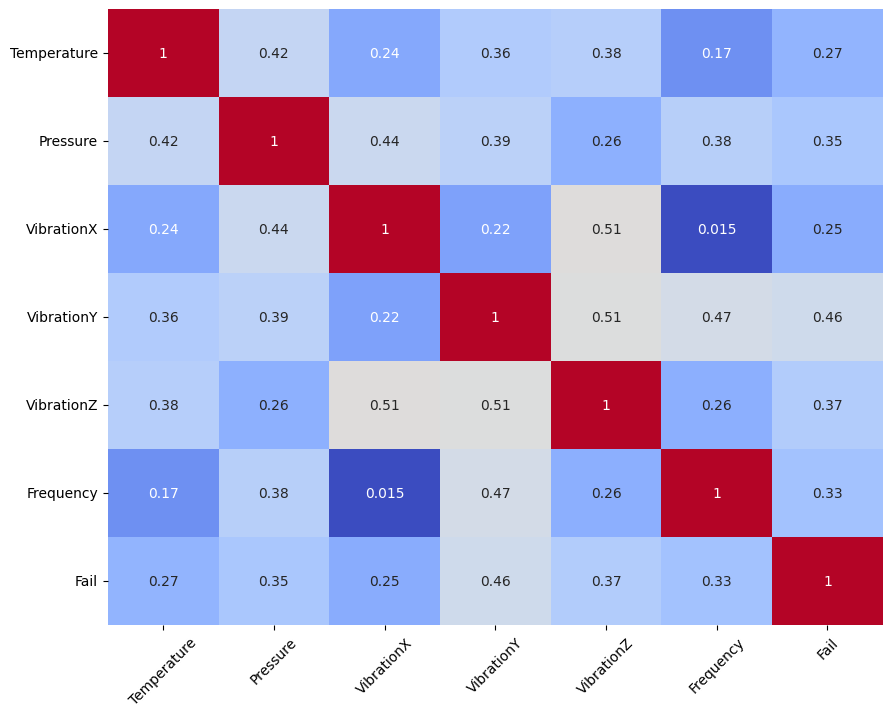

In [13]:
correlation_df = df[['Temperature', 'Pressure', 'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency', 'Fail']].copy()


correlation_matrix = correlation_df.corr()


fig, ax = plt.subplots(figsize=(10, 8))


sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=ax, cbar=False)


plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.show()

In [14]:

correlation_abs = correlation_matrix.abs()


different_than_1 = correlation_abs[correlation_abs != 1]

ranked_correlations = different_than_1.unstack().sort_values(ascending=False)
ranked_correlations = ranked_correlations.reset_index()
ranked_correlations.columns = ['column_A', 'column_B', 'Corr']


ranked_correlations = ranked_correlations[ranked_correlations['column_A']=='Fail']

ranked_correlations.head(6)

,column_A,column_B,Corr
6,Fail,VibrationY,0.455435
19,Fail,VibrationZ,0.367857
23,Fail,Pressure,0.345497
25,Fail,Frequency,0.325286
26,Fail,Temperature,0.272666
33,Fail,VibrationX,0.252754


# Classificar as falhas dos equipamentos de acordo com as configurações de instalação  (preset 1 and preset 2).


Com base na análise abrangente e no estudo realizado, pode-se afirmar que a configuração com a categoria 1 da predefinição 1 apresenta a maior probabilidade de encontrar problemas nos equipamentos, seguida pelas configurações da predefinição 2 e predefinição 3.

Em relação à configuração da predefinição 2, as cinco categorias mais associadas a uma maior probabilidade de problemas nos equipamentos são 5, 1, 6, 2 e 7.

Ao realizar um estudo avançado considerando a análise combinada das configurações da predefinição 1 e da predefinição 2, observa-se que as configurações em que a predefinição 1 é 1 e a predefinição 2 é 5, a predefinição 1 é 3 e a predefinição 2 é 5, a predefinição 1 é 2 e a predefinição 2 é 1 e a predefinição 1 é 1 e a predefinição 2 é 2 representam coletivamente 56% das falhas observadas nos equipamentos.

**0 = False and 1 = True**

### Preset 1

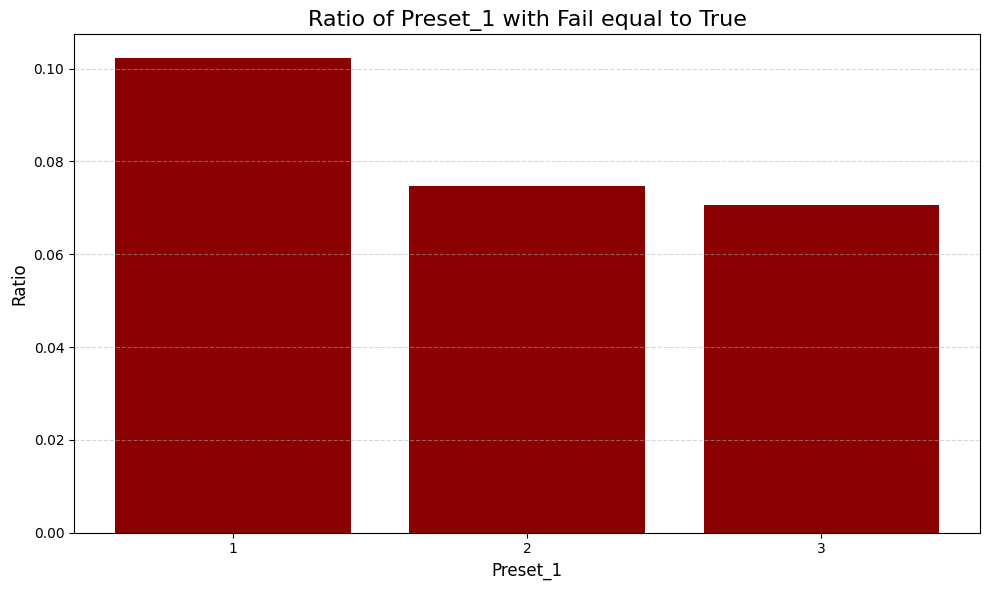

In [15]:
df_Preset_1 = df[['Preset_1', 'Fail']]
total_occurrences = df_Preset_1['Preset_1'].value_counts()
preset_1_fail_1_occurrences = df_Preset_1[df_Preset_1['Fail'] == 1]['Preset_1'].value_counts()
ratio = preset_1_fail_1_occurrences / total_occurrences
ratio = ratio.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(ratio.index, ratio.values, color='darkred')
plt.title("Ratio of Preset_1 with Fail equal to True", fontsize=16)
plt.xlabel("Preset_1", fontsize=12)
plt.ylabel("Ratio", fontsize=12)
plt.xticks()
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Preset 2


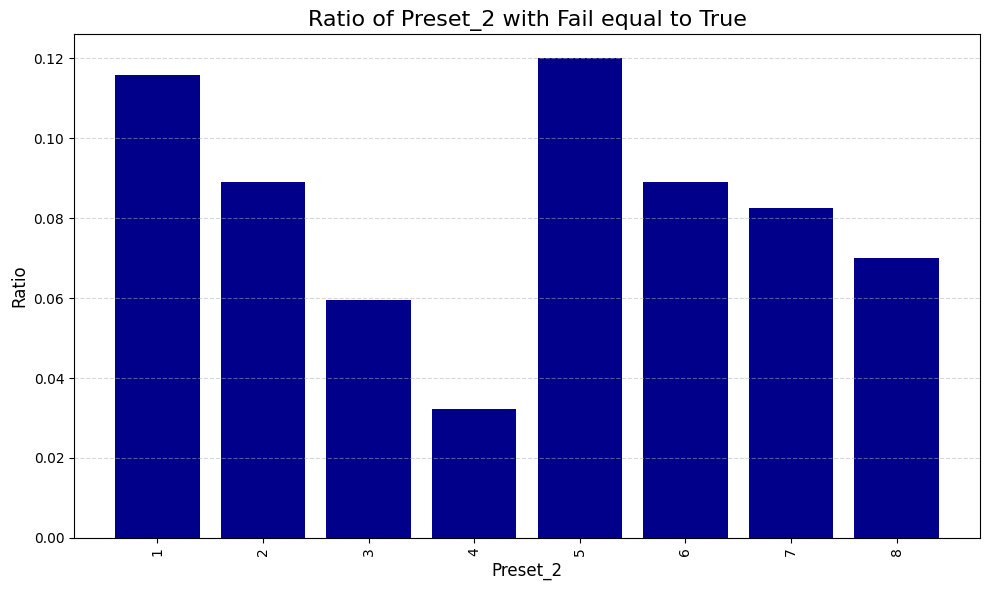

In [16]:

df_Preset_2 = df[['Preset_2', 'Fail']]
total_occurrences = df_Preset_2['Preset_2'].value_counts()
preset_2_fail_1_occurrences = df_Preset_2[df_Preset_2['Fail'] == 1]['Preset_2'].value_counts()
ratio = preset_2_fail_1_occurrences / total_occurrences
ratio_sorted = ratio.sort_values()

plt.figure(figsize=(10, 6))
plt.bar(ratio_sorted.index, ratio_sorted.values, color='darkblue')
plt.title("Ratio of Preset_2 with Fail equal to True", fontsize=16)
plt.xlabel("Preset_2", fontsize=12)
plt.ylabel("Ratio", fontsize=12)
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()





Concatenando informações da preset-1 e da preset-2 para determinar qual delas, juntas, têm um impacto maior nas falhas de equipamento.

In [17]:
X = df[['Preset_1', 'Preset_2', 'Fail']]
X["Concatenated_Presets"] = X["Preset_1"].astype(str) + "&" + X["Preset_2"].astype(str)
X = X[['Concatenated_Presets', 'Fail']]

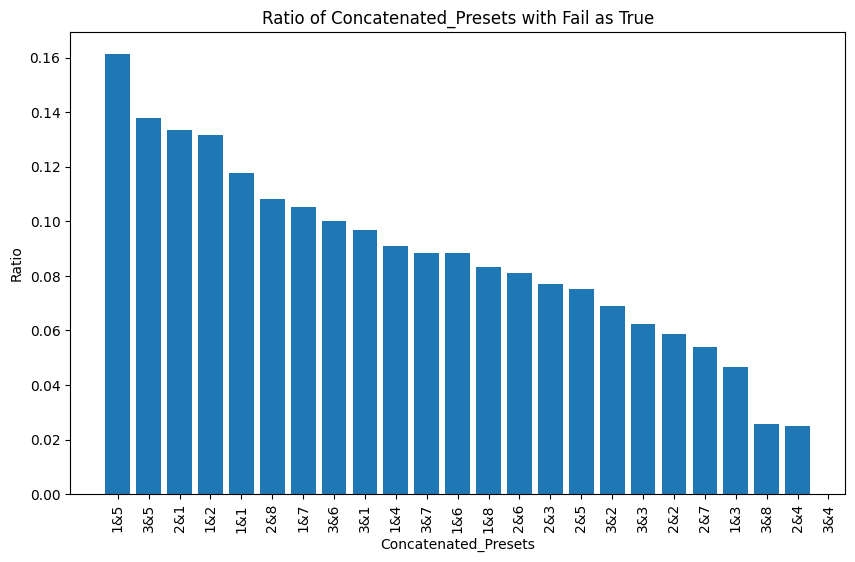

In [18]:
total_occurrences = X['Concatenated_Presets'].value_counts()
fail_1_occurrences = X[X['Fail'] == 1]['Concatenated_Presets'].value_counts()
ratio = fail_1_occurrences / total_occurrences
ratio = ratio.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(ratio.index, ratio.values)
plt.title("Ratio of Concatenated_Presets with Fail as True")
plt.xlabel("Concatenated_Presets")
plt.ylabel("Ratio")
plt.xticks(rotation=90)
plt.show()

In [19]:
# Presets1 and 2: 1&5, 3&5, 2$1 and 1&2
ratio.head(4).sum()

0.5641336377651581

#Categorizar as falhas de equipamento de acordo com sua natureza/origem com base nas leituras dos parâmetros (temperatura, pressão e outros).

 A ideia era criar uma coluna contendo informações categóricas, o que significa agrupar dados numéricos em categorias, usando uma análise conjunta das seguintes informações: temperatura, pressão, vibrações e frequência. A abordagem foi baseada em estatísticas e utilizou os quartis do conjunto de dados onde o equipamento sofreu falhas. Para cada uma das variáveis mencionadas, conduzi uma análise e calculei a média para cada quartil. Esse processo resultou na criação de quatro novas categorias de avaliação de risco:

* no risk: Nenhum risco presente para a máquina.
* minimum risk : Um risco baixo que requer alguma atenção.
* real risk : Risco real provável de encontrar problemas com a máquina, requer atenção.
* high risk : Risco com um nível de preocupação elevado, ação deve ser tomada para evitar falhas.
* very high risk: Risco emergente, ação imediata deve ser tomada.

In [20]:
df_true = df[df['Fail']==True]
df_false = df[df['Fail']==False]

In [21]:
df_true = df_true[['Temperature', 'Pressure',
       'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency']]

df_false = df_false[['Temperature', 'Pressure',
       'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency']]

In [22]:

df_false_describe = df_false.describe()
df_true_describe = df_true.describe()

min_line = df_true_describe.iloc[3]
line_25_percent = df_true_describe.iloc[4]
line_50_percent = df_true_describe.iloc[5]
line_75_percent = df_true_describe.iloc[6]

minimum_alert = min_line.mean()
medium_alert = line_25_percent.mean()
high_alert = line_50_percent.mean()
very_high_alert = line_75_percent.mean()

columns = ['Temperature', 'Pressure', 'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency']
selected_df = df[columns]

row_means = selected_df.mean(axis=1)

df['mean'] = row_means

df['alert'] = ''
df.loc[df['mean'] < minimum_alert, 'alert'] = 'no_risk, '
df.loc[df['mean'] > minimum_alert, 'alert'] = 'minimum_risk'
df.loc[df['mean'] > medium_alert, 'alert'] = 'real_risk '
df.loc[df['mean'] > high_alert, 'alert'] = 'high_risk, '
df.loc[df['mean'] > very_high_alert, 'alert'] = 'very_high_risk'

## Nova análise de categorias
Como esperado, as máquinas com o status de sem falhas predominantemente apresentaram categorias de sem risco e risco mínimo, representando quase 93% delas. Por outro lado, entre as máquinas que experimentaram falhas, mais da metade delas tinha a categoria de risco real, aproximadamente 36% tinham alto risco e apenas 8% tinham risco muito alto.

In [23]:
test_false = df[df['Fail']==False]
test_true = df[df['Fail']==True]

In [24]:
test_true.alert.value_counts()/test_true.shape[0]

real_risk         0.560606
high_risk,        0.363636
very_high_risk    0.075758
Name: alert, dtype: float64

In [25]:
test_false.alert.value_counts()/test_false.shape[0]

minimum_risk    0.881471
real_risk       0.058583
no_risk,        0.040872
high_risk,      0.019074
Name: alert, dtype: float64

# Criando um modelo utilizando a técnica que você acredita ser mais apropriada e meça seu desempenho.
A ideia principal era criar o melhor modelo para prever as situações estudadas, a fim de prevenir futuros casos de falha de equipamento, o que poderia resultar em custos significativos para a empresa. Para alcançar isso, testei seis modelos de classificação diferentes usando a pesquisa em grade, que é uma busca exaustiva realizada em valores específicos dos parâmetros de um modelo.

Para conduzir este teste, tivemos que abordar o problema de dados desequilibrados usando a técnica SMOTE, que envolve a geração de pontos de dados sintéticos para o nosso conjunto de dados. Como mencionado anteriormente, também escalamos nossas variáveis e codificamos as informações categóricas.

Os resultados serão discutidos nos próximos passos.

## Algoritmos de Aprendizado de Máquina para Classificação
### Análise do Modelo

In [26]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Cycle        800 non-null    int64  
 1   Preset_1     800 non-null    int64  
 2   Preset_2     800 non-null    int64  
 3   Temperature  800 non-null    float64
 4   Pressure     800 non-null    float64
 5   VibrationX   800 non-null    float64
 6   VibrationY   800 non-null    float64
 7   VibrationZ   800 non-null    float64
 8   Frequency    800 non-null    float64
 9   Fail         800 non-null    bool   
 10  mean         800 non-null    float64
 11  alert        800 non-null    object 
dtypes: bool(1), float64(7), int64(3), object(1)
memory usage: 69.7+ KB


In [27]:
#Escalonar
df['Fail'] = df['Fail'].astype('object')

colunas_numericas = df.select_dtypes(include=['float64', 'int64']).columns
colunas_categoricas = df.select_dtypes(include=['object']).columns

scaler = MinMaxScaler()
df[colunas_numericas] = scaler.fit_transform(df[colunas_numericas])

encoder = LabelEncoder()
for col in colunas_categoricas:
    df[col] = encoder.fit_transform(df[col])


df_encoded = df.copy()


In [28]:
df_encoded.head()

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail,mean,alert
0,0.000000,1.0,0.714286,0.166244,0.236854,0.187633,0.298414,0.224683,0.230862,0,0.219093,1
1,0.001252,0.5,0.428571,0.231612,0.320037,0.256193,0.385024,0.294401,0.321505,0,0.376072,1
2,0.002503,0.5,0.000000,0.303482,0.426517,0.347095,0.480604,0.377066,0.441041,0,0.567218,1
3,0.003755,0.5,0.285714,0.306198,0.520216,0.522063,0.606530,0.470706,0.437139,0,0.734376,0
4,0.005006,0.5,0.571429,0.149495,0.258877,0.170332,0.277803,0.150506,0.344626,0,0.212712,1


### Balanciamento e escolanmento

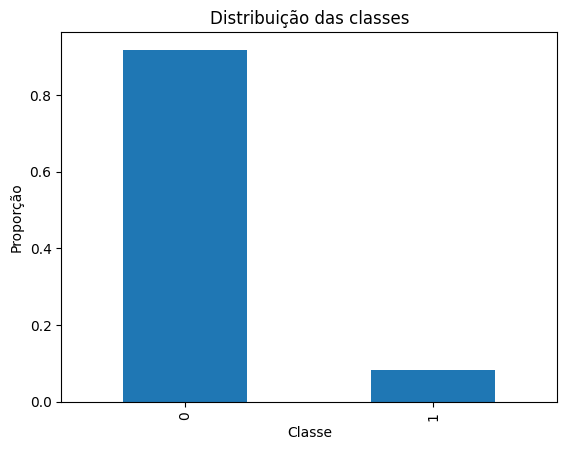

In [29]:
contagem_classes = df_encoded["Fail"].value_counts()
proporcao_classes = contagem_classes / contagem_classes.sum()
proporcao_classes.plot(kind='bar')
plt.xlabel('Classe')
plt.ylabel('Proporção')
plt.title('Distribuição das classes')
plt.show()

In [30]:
# Dividir entre traino e teste
X = df_encoded.drop(['Fail'], axis=1)
y = df_encoded["Fail"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [31]:
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Contagem das classes antes do balanceamento:")
print(y.value_counts())

print("Contagem das classes depois do balanceamento:")
print(pd.Series(y_train_resampled).value_counts())

Contagem das classes antes do balanceamento:
0    734
1     66
Name: Fail, dtype: int64
Contagem das classes depois do balanceamento:
0    518
1    518
Name: Fail, dtype: int64


# Aplicar modelos e avaliação
Utilizei um formato de pipeline para executar todos os modelos de uma só vez, o que ajudou a economizar tempo.

In [32]:
model_pipeline = []
model_pipeline.append(LogisticRegression())
model_pipeline.append(SVC())
model_pipeline.append(DecisionTreeClassifier())
model_pipeline.append(RandomForestClassifier())
model_pipeline.append(GaussianNB())
model_pipeline.append(GradientBoostingClassifier())

In [33]:
X_train_resampled

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,mean,alert
0,0.096370,0.000000,0.428571,0.303515,0.543843,0.268628,0.494281,0.246044,0.383819,0.515243,1
1,0.511890,1.000000,0.428571,0.371370,0.768038,0.555657,0.599263,0.334502,0.674790,0.870231,0
2,0.709637,0.000000,1.000000,0.333946,0.558375,0.376632,0.193213,0.331441,0.436404,0.526833,1
3,0.604506,0.500000,0.857143,0.397762,0.485511,0.274424,0.333641,0.201288,0.451287,0.493676,1
4,0.136421,1.000000,0.571429,0.227375,0.250278,0.293080,0.382574,0.288274,0.776079,0.495376,1
...,...,...,...,...,...,...,...,...,...,...,...
1031,0.761505,0.329275,0.951221,0.264249,0.659521,0.261661,0.671301,0.239444,0.688175,0.672074,3
1032,0.823990,1.000000,0.814780,0.398029,0.800133,0.500528,0.530360,0.402655,0.511147,0.826212,0
1033,0.601282,1.000000,0.714286,0.422688,0.752577,0.490287,0.390494,0.478099,0.563287,0.816958,0
1034,0.681744,1.000000,0.857143,0.382032,0.635375,0.436430,0.687228,0.487318,0.490106,0.815797,0


In [34]:
param_grid_lr = {'C': [0.01,0.1, 1, 10, 50,100,150]}
param_grid_svc = {'C': [0.01,0.1, 1, 10, 50,100], 'kernel': ['linear', 'rbf']}
param_grid_dt = {'max_depth': [None, 10, 20, 30,40,150]}
param_grid_rf = {'n_estimators': [100, 200, 300]}
param_grid_nb = {}
param_grid_gb = {'n_estimators': [10,20],'learning_rate': [0.01, 0.1, 1, 10],'max_depth': [3, 5]}

param_grids = [param_grid_lr, param_grid_svc, param_grid_dt, param_grid_rf, param_grid_nb,param_grid_gb]

best_models = []
best_params = []
for i, model in enumerate(model_pipeline):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[i], scoring='f1', cv=30)
    grid_search.fit(X_train_resampled, y_train_resampled)
    best_model = grid_search.best_estimator_
    best_models.append(best_model)
    best_params.append(grid_search.best_params_)


acc_eval = []
auc_eval = []
f1_eval = []
recall_eval = []
cm_eval = []

for model in best_models:
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    acc_eval.append(accuracy_score(y_test, y_pred))
    fpr, tpr, _thresholds = roc_curve(y_test, y_pred)
    auc_eval.append(round(auc(fpr, tpr), 2))
    f1_eval.append(round(f1_score(y_test, y_pred), 2))
    recall_eval.append(round(recall_score(y_test, y_pred), 2))
    cm_eval.append(confusion_matrix(y_test, y_pred))

## Métrica

* Accuracy
* Recall
* AUC

In [35]:
model_list = ['Logistic Regression', 'SVM', 'Decision Tree', 'Random Forest', 'Naive Bayes','Gradient Boosting']
acc_eval = []
auc_eval = []
recall_eval = []
cm_eval = []

for model in model_pipeline:
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    acc_eval.append(accuracy_score(y_test, y_pred))
    fpr, tpr, _thresholds = roc_curve(y_test, y_pred)
    auc_eval.append(round(auc(fpr, tpr), 2))
    recall_eval.append(round(recall_score(y_test, y_pred), 2))
    cm_eval.append(confusion_matrix(y_test, y_pred))

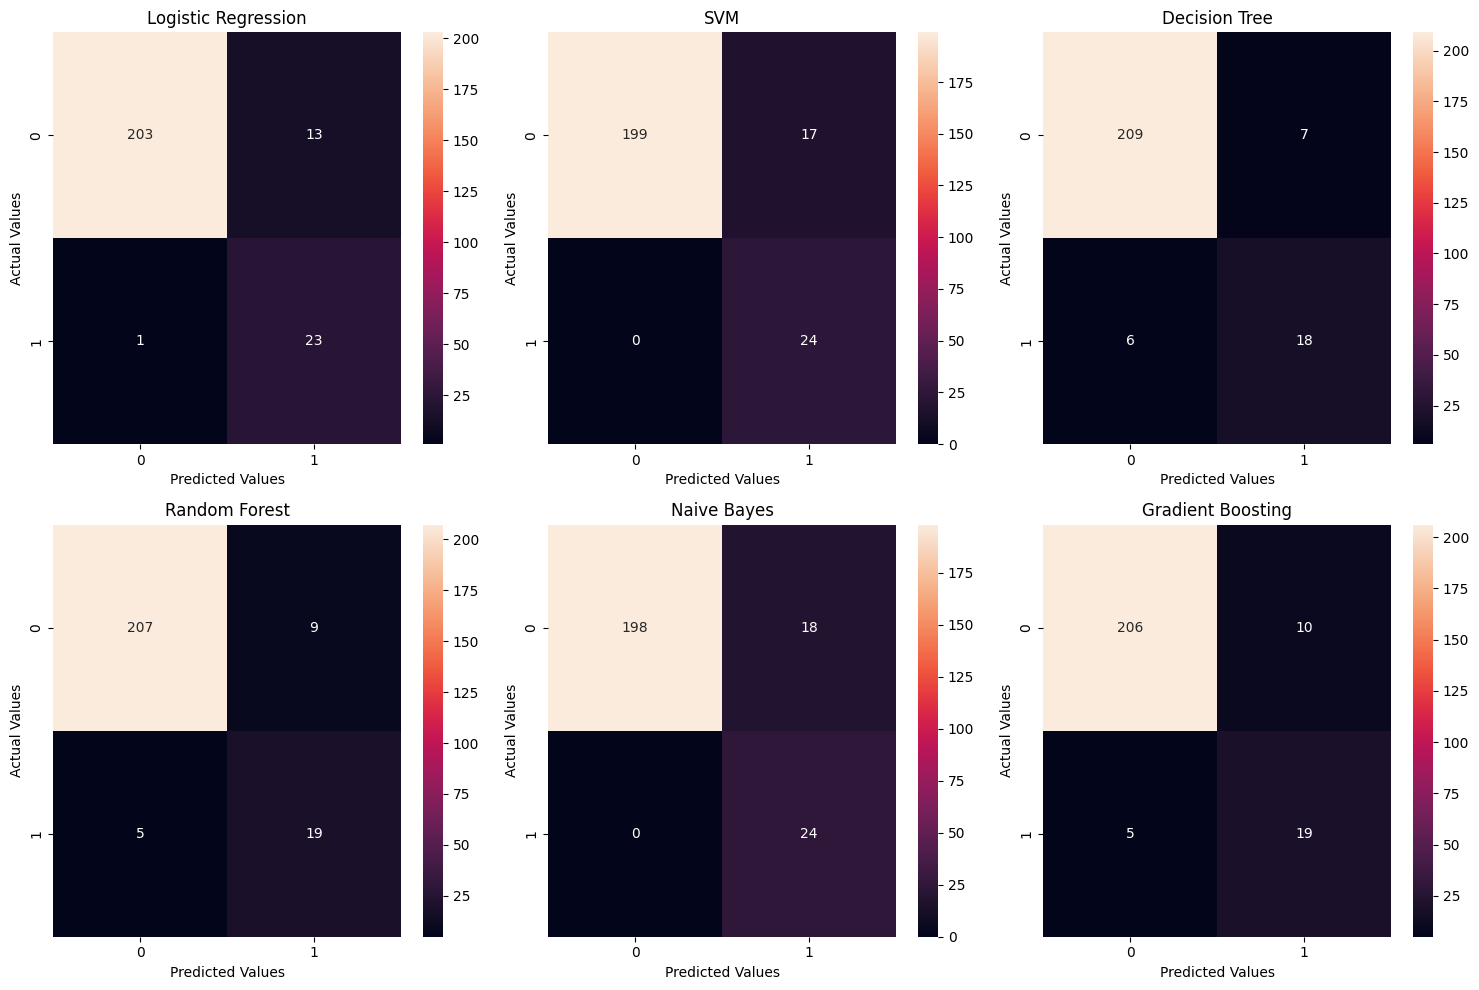

In [36]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  # Ajuste o figsize para um tamanho maior

for i, ax in enumerate(axes.flatten()):
    cm = cm_eval[i]
    model = model_list[i]
    sns.heatmap(cm, annot=True, fmt='.0f', ax=ax)
    ax.set_title(model)
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values')

plt.tight_layout()
plt.show()

In [37]:
results = pd.DataFrame({'Model': model_list, 'Accuracy': acc_eval, 'Recall': recall_eval, 'AUC': auc_eval})

In [38]:
results

,Model,Accuracy,Recall,AUC
0,Logistic Regression,0.941667,0.96,0.95
1,SVM,0.929167,1.00,0.96
2,Decision Tree,0.945833,0.75,0.86
3,Random Forest,0.941667,0.79,0.88
4,Naive Bayes,0.925000,1.00,0.96
5,Gradient Boosting,0.937500,0.79,0.87


# Resultados
Como podemos ver, os modelos que obtiveram os melhores resultados para nossas necessidades são:

* Support Vector Machine (SVM)
* Naive Bayes
* Regressão Logística
Os três modelos apresentaram resultados muito bons, com uma alta taxa de revocação, além de acurácia e AUC. Também selecionei esses 3 modelos por estas razões:

## Support Vector Machine (SVM):
O SVM é um algoritmo de aprendizado supervisionado e muito versátil.
É eficiente em espaços de alta dimensionalidade e pode lidar com dados não lineares.
O SVM procura encontrar um hiperplano que maximize a margem entre diferentes classes, permitindo uma boa generalização para novos dados.
É especialmente útil quando há um número relativamente pequeno de amostras de treinamento, mas com alta dimensionalidade.
Pode ser eficaz em problemas de classificação binária e também pode ser estendido para problemas de classificação multiclasse.

## Naive Bayes:
O Naive Bayes é um algoritmo de classificação baseado no teorema de Bayes e na suposição de independência condicional entre as características (daí o termo "ingênuo").
É eficiente computacionalmente e pode ser treinado rapidamente com conjuntos de dados em grande escala.
Embora faça suposições simplificadas sobre os dados.
É particularmente adequado para tarefas de classificação de texto e mineração de dados, funcionando muito bem no cenário que temos.
Também pode ser útil como um classificador base em sistemas de aprendizado de conjunto.

## Regressão Logística:
A Regressão Logística é um modelo estatístico usado para problemas de classificação binária.
Ela estima as probabilidades de pertencer a uma classe específica usando uma função logística (também conhecida como função sigmóide).
É relativamente fácil de interpretar e pode fornecer insights sobre a importância de diferentes características para a classificação.
Pode lidar com dados contínuos e categóricos, bem como interações entre características.
Pode ser estendida para problemas de classificação multiclasse usando técnicas como One-vs-Rest ou Regressão Softmax.

## Visão geral das métricas
### Revocação:
A taxa de revocação mede a proporção de exemplos positivos classificados corretamente em relação ao número total de exemplos positivos no conjunto de dados. É uma métrica importante em problemas em que a detecção de casos positivos é crítica. Uma alta taxa de revocação indica que o modelo está identificando corretamente uma grande parte dos exemplos positivos. Isso é particularmente útil em situações em que falsos negativos podem ter sérias consequências.

### Acurácia:
A taxa de acurácia mede a proporção de exemplos classificados corretamente, tanto positivos quanto negativos, em relação ao número total de exemplos no conjunto de dados. Uma alta acurácia indica que o modelo está fazendo previsões corretas na maioria dos casos. No entanto, é importante considerar o equilíbrio entre as classes. Se o conjunto de dados estiver desequilibrado (ou seja, uma classe for muito mais frequente do que a outra), uma alta acurácia pode ser enganosa. Nesses casos, é recomendável avaliar outras métricas, como revocação e precisão, para obter uma visão mais abrangente do desempenho do modelo.

### Área sob a Curva ROC (AUC):
A AUC é uma métrica usada para avaliar a qualidade de um modelo de classificação binária. Ela representa a probabilidade de que um exemplo positivo escolhido aleatoriamente seja classificado corretamente com uma probabilidade maior do que um exemplo negativo escolhido aleatoriamente. Quanto mais próxima de 1 for a AUC, melhor será o desempenho do modelo em distinguir entre as duas classes. Ter uma AUC alta indica que o modelo está apresentando uma separação clara entre as classes e fazendo boas previsões.

## Conclusão
Este estudo teve como objetivo compreender as situações de falha na operação de equipamentos FPSO e as variáveis que contribuíram para suas falhas em diversos cenários. As situações relacionadas a sensores e variações naturais foram mapeadas. O principal objetivo foi seguir o roteiro das 5 perguntas propostas e, ao longo da análise, fomos capazes de respondê-las. Além disso, criamos pelo menos 3 modelos para uso futuro.